# Imports

In [1]:
#Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [4]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [5]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 1min 55s, sys: 4.63 s, total: 2min
Wall time: 1min 59s


# Data selection 

In [6]:
import numpy as np
from itertools import product

# Функция для генерации подгрупп (subgroups)
def generate_subgroups(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    for i in range(1, n + 1):  # Генерация комбинаций длиной от 1 до n
        subgroups.extend([''.join(p) for p in product(nucleotides, repeat=i)])
    return subgroups

# Функция для кодирования последовательности
def encode_sequence_as_features_ndarray(sequence, subgroups, max_length):
    # Итоговый список признаков для всей последовательности
    features_list = []

    # Генерация признаков для каждого нуклеотида
    for i in range(len(sequence)):
        features = [0] * len(subgroups)  # Инициализируем список признаков для текущей позиции
        
        for j, group in enumerate(subgroups):
            group_length = len(group)
            
            # Проверяем соответствие текущей позиции
            if group_length == 1:  # Для одиночных классов
                if sequence[i] == group:
                    features[j] = 1
            elif group_length > 1:  # Для классов длиной > 1
                # Проверяем подстроку длиной group_length перед и после текущей позиции
                start = i - group_length + 1
                end = i + group_length
                if start >= 0 and sequence[start:i + 1] == group:  # Слева
                    features[j] = 1
                elif end <= len(sequence) and sequence[i:end] == group:  # Справа
                    features[j] = 1
        
        # Добавляем признаки для текущей позиции в общий список
        features_list.append(features)
    
    # Преобразуем список списков в numpy.ndarray
    return np.array(features_list)

In [7]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source, 
                 labels_source, intervals, k_mer=1, groups=['A','T','G','C'], lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.lrp_feat = lrp_feat
        
        self.k_mer = k_mer
        self.groups = groups

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        
        dna_OHE = encode_sequence_as_features_ndarray(self.dna_source[chrom][begin:end].upper(), self.groups, self.k_mer)

        X = dna_OHE.astype(np.float32)
            
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(lrp_feat)]

        return (X, y)

In [8]:
width = 100

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 47446.88it/s]


In [9]:
ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

In [10]:
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

In [11]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# All models

In [12]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from IPython.display import clear_output

In [13]:
class DeepCNNLayerNorm_v3(nn.Module): # 15 слоев
    def __init__(self, features_count):
        super().__init__()
        self.seq = nn.Sequential(
            
            nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([3, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(3, 5, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([5, 100, features_count]),
            nn.ReLU(),
            
            
            nn.Conv2d(5, 7, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([7, 100, features_count]),
            nn.ReLU(),
            
            
            nn.Conv2d(7, 9, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([9, 100, features_count]),
            nn.ReLU(),
            
            
            nn.Conv2d(9, 11, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([11, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(11, 13, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([13, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(13, 15, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([15, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(15, 15, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Conv2d(15, 13, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([13, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(13, 11, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([11, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(11, 9, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([9, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(9, 7, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([7, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(7, 5, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([5, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(5, 3, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([3, 100, features_count]),
            nn.ReLU(),
            
            nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([1, 100, features_count]),  # Укажите размеры после свертки
            nn.ReLU(),
            
            
            nn.Dropout(0.25),
            
            nn.Linear(features_count, 500),
            nn.Dropout(0.25),
            nn.ReLU(),
            
            nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, features_count)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

# Train and test

In [14]:
import time
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(output, y_batch)


def train_epoch(model, optimizer, loader_train):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()
    for X_batch, y_batch in loader_train:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        
        output = model(X_batch)
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()
        
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    y_pred)
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output.permute([0, 2, 1]), y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def test(model, loader_test):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in loader_test:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()
        
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    y_pred)
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten())
        
        f1_log.append(f1)
        
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        if output.dim() == 2:  
            output = output.unsqueeze(0)
        loss = loss_func(output.permute([0, 2, 1]), y_batch)
        loss = loss.item()
        loss_log.append(loss)
        
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, loader_train, loader_test, k_mer):
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []
    
    for epoch in range(n_epochs):
        print(f"Max {max_length}-mer. Epoch {epoch + 1} of {n_epochs}")
        
        start_time = time.time()
        
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt, loader_train)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model, loader_test)
        
        end_time = time.time()
        t = end_time - start_time
        times.append(t)
        
        BatchSize = len(train_loss)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
#         raise BaseException
        
        
        clear_output()
        plot_history(train_loss_log, val_loss_log, 'Loss', len(train_loss))
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss))
        plot_history(train_pr_log, val_pr_log, 'Precision', len(train_loss))
        plot_history(train_rec_log, val_rec_log, 'Recall', len(train_loss))
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss))
        print("Time: ", t/60)
        print(f"Max {max_length}-mer. Epoch {epoch+1}: ROC-AUC = {val_auc_log[-1]:.3}")
        print(f"Max {max_length}-mer. Epoch {epoch+1}:  Precision = {val_pr_log[-1]:.3}")
        print(f"Max {max_length}-mer. Epoch {epoch+1}: Recall = {val_rec_log[-1]:.3}")
        print(f"Max {max_length}-mer. Epoch {epoch+1}: F1-score = {val_f1_log[-1]:.3}")
        
        #'Model	k mers	Dataset	Interval size	F1-score	ROC-AUC	Presicion	Recall	Time'
        worksheet_log.append_row(["DeepCNNLayerNorm_v3",
                              f'{max_length}',
                              'Kouzine-Wu',
                              '100',
                              f'{epoch}',
                              f'{val_f1_log[-1]:.3}',
                              f'{val_auc_log[-1]:.3}',
                              f'{val_pr_log[-1]:.3}',
                              f'{val_rec_log[-1]:.3}',
                              f'{t/60:.3}'
                             ]
                            )
            
            
           
    print(f"Max {max_length}-mer. Final ROC-AUC = {val_auc_log[-1]:.3}")
    print(f"Max {max_length}-mer. Final Precision = {val_pr_log[-1]:.3}")
    print(f"Max {max_length}-mer. Final Recall = {val_rec_log[-1]:.3}")
    print(f"Max {max_length}-mer. Final F1-score = {val_f1_log[-1]:.3}")
    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times    

In [15]:
!pip install gspread pandas gspread-dataframe oauth2client


[notice] A new release of pip is available: 24.1.2 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [16]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]

creds = ServiceAccountCredentials.from_json_keyfile_name("service_account.json", scope)
client = gspread.authorize(creds)

spreadsheet = client.open_by_key("1rrtglWxDCSYMpeicqSFxKBbnLLcufIPyl_HslhDo_WQ")
worksheet = spreadsheet.worksheet('ATGC CNN')  

worksheet.append_row(["2025-01-29", "Пример", 100])

{'spreadsheetId': '1rrtglWxDCSYMpeicqSFxKBbnLLcufIPyl_HslhDo_WQ',
 'tableRange': "'ATGC CNN'!A1:I21",
 'updates': {'spreadsheetId': '1rrtglWxDCSYMpeicqSFxKBbnLLcufIPyl_HslhDo_WQ',
  'updatedRange': "'ATGC CNN'!A22:C22",
  'updatedRows': 1,
  'updatedColumns': 3,
  'updatedCells': 3}}

In [17]:
worksheet_log = spreadsheet.worksheet('ATGC CNN logs')
worksheet_log.append_row(["2025-01-29", "Пример", 100])

{'spreadsheetId': '1rrtglWxDCSYMpeicqSFxKBbnLLcufIPyl_HslhDo_WQ',
 'tableRange': "'ATGC CNN logs'!A1:J64",
 'updates': {'spreadsheetId': '1rrtglWxDCSYMpeicqSFxKBbnLLcufIPyl_HslhDo_WQ',
  'updatedRange': "'ATGC CNN logs'!A65:C65",
  'updatedRows': 1,
  'updatedColumns': 3,
  'updatedCells': 3}}

# Запуски

In [22]:
def generate_subgroups_just_n(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    subgroups.extend([''.join(p) for p in product(nucleotides, repeat=n)])
    return subgroups

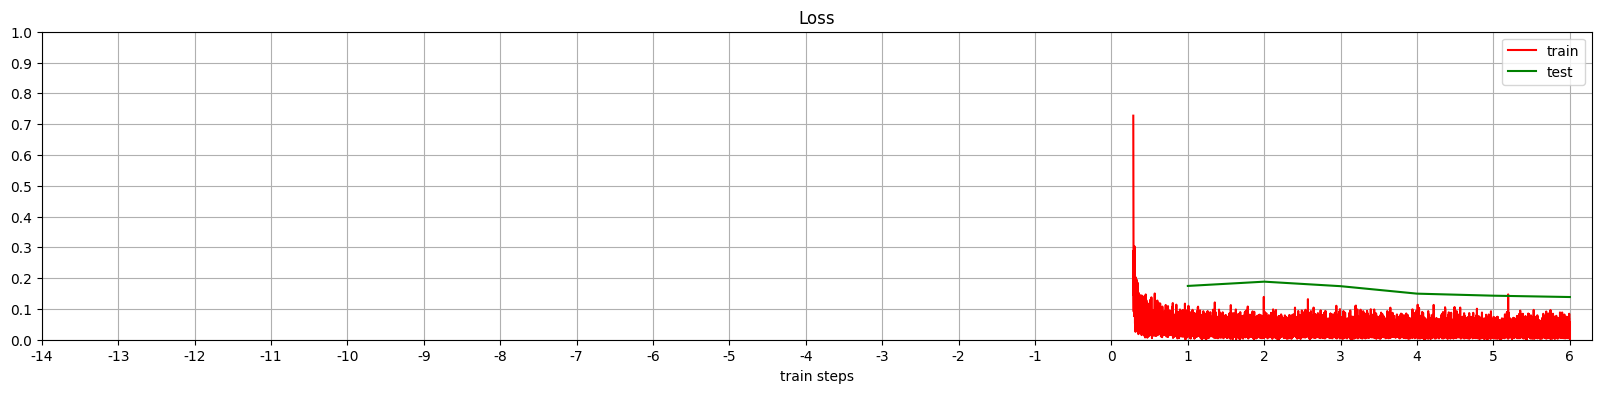

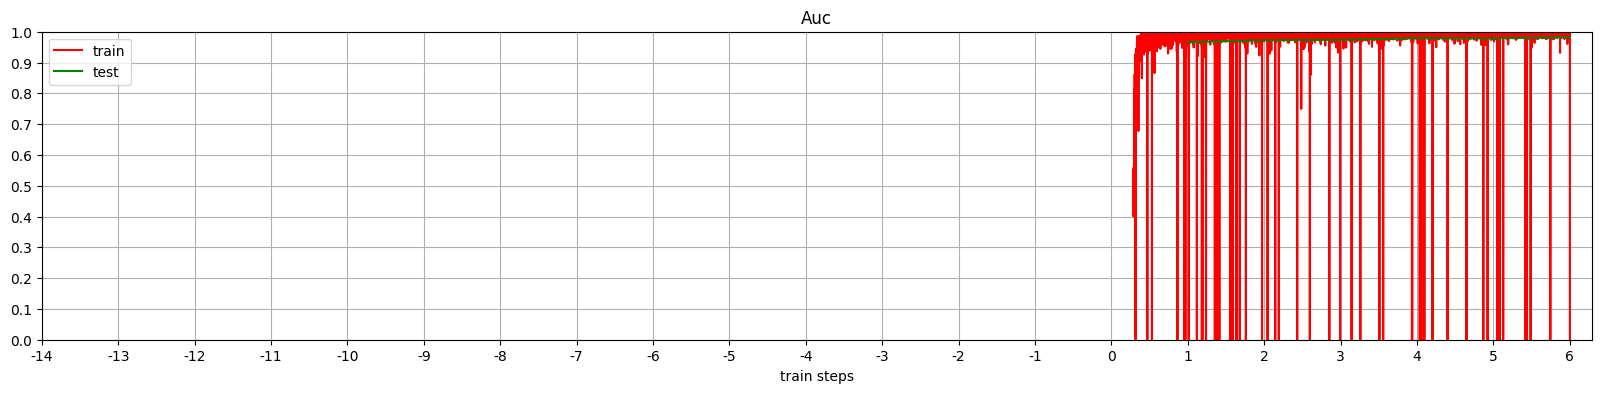

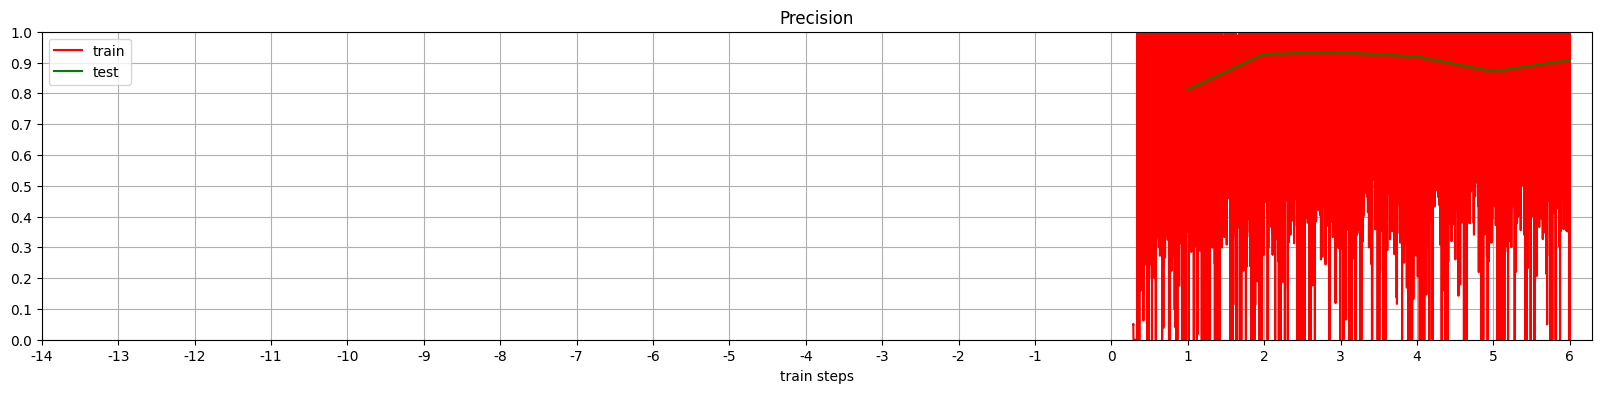

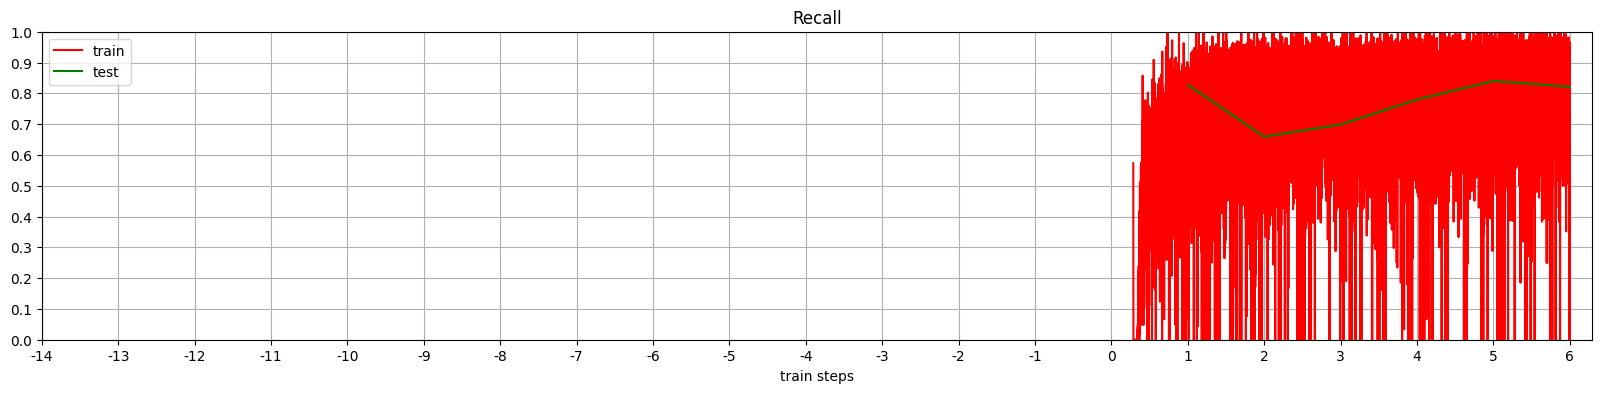

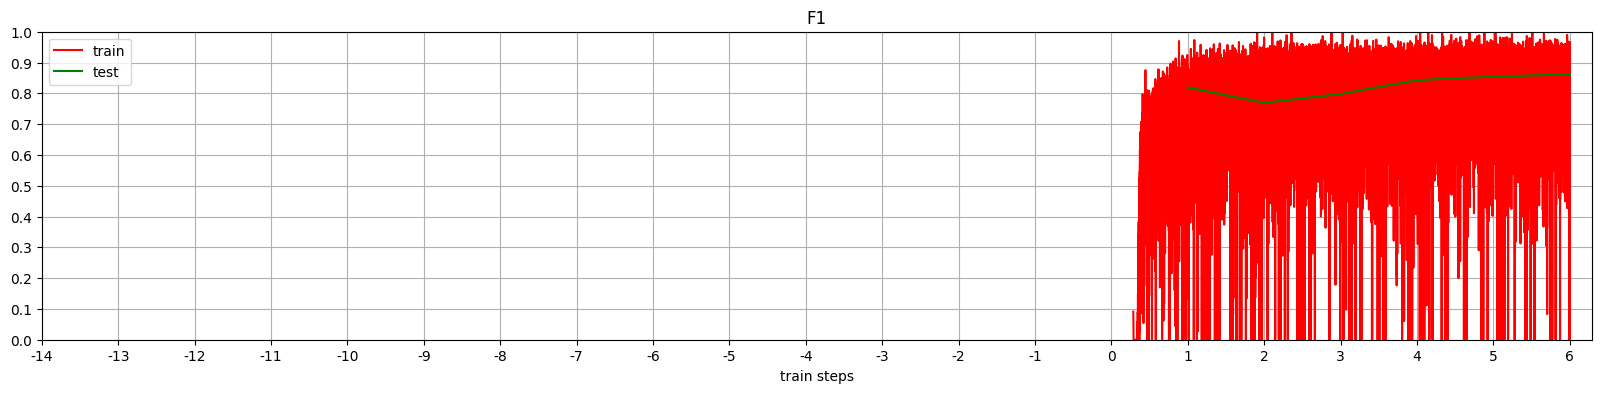

Time:  11.856226329008738
Max 4-mer. Epoch 6: ROC-AUC = 0.982
Max 4-mer. Epoch 6:  Precision = 0.908
Max 4-mer. Epoch 6: Recall = 0.821
Max 4-mer. Epoch 6: F1-score = 0.862
Max 4-mer. Final ROC-AUC = 0.982
Max 4-mer. Final Precision = 0.908
Max 4-mer. Final Recall = 0.821
Max 4-mer. Final F1-score = 0.862


In [23]:
max_length = 4
groups = generate_subgroups(max_length)
features_count = len(groups)

np.random.seed(42)

train_dataset = Dataset(chrom_names, feature_names, 
                   DNA, DNA_features, 
                   ZDNA, train_intervals, max_length, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                   DNA, DNA_features, 
                   ZDNA, test_intervals, max_length, groups, lrp_feat = [])


params = {'batch_size':32,
      'num_workers':4,
      'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

torch.cuda.empty_cache()
set_random_seed(42)

model = DeepCNNLayerNorm_v3(features_count)
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 6, loader_train, loader_test, max_length)

    
worksheet.append_row(["DeepCNNLayerNorm_v3",
                      f'{features_count}',
                      f'{max_length}',
                      'Kouzine-Wu',
                      '100',
                      f'{val_f1_log[np.argmax(val_f1_log)]:.3}',
                      f'{np.argmax(val_f1_log)}',
                      f'{val_auc_log[np.argmax(val_f1_log)]:.3}',
                      f'{np.mean(times) / 60:.3}'
                     ]
                    )
    
model_metric = {'Epoch':np.argmax(val_f1_log),
                'Max F1-score':val_f1_log[np.argmax(val_f1_log)],
                'ROC-AUC':val_auc_log[np.argmax(val_f1_log)],
                'Precision':val_pr_log[np.argmax(val_f1_log)],
                'Recall':val_rec_log[np.argmax(val_f1_log)],
                'Mean time':np.mean(times) / 60
               }


In [25]:
torch.save(model, 'model_CNN_1234_86.pt')

In [21]:
model_metric

{'Epoch': 5,
 'Max F1-score': 0.8616312920190244,
 'ROC-AUC': 0.9821125890708697,
 'Precision': 0.9080512624668649,
 'Recall': 0.8212812026657405,
 'Mean time': 11.799767187833787}

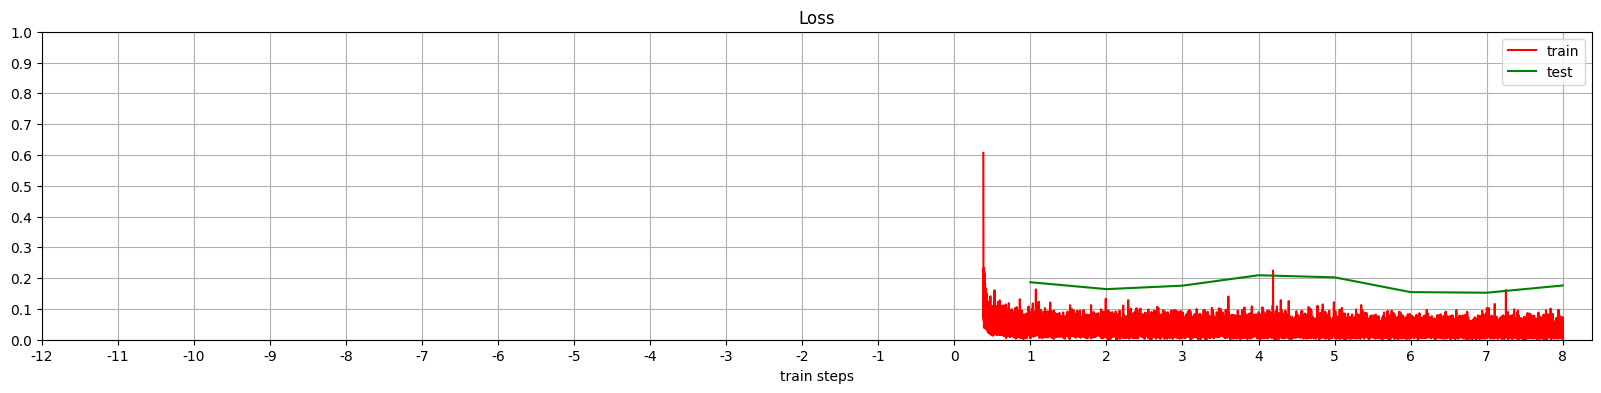

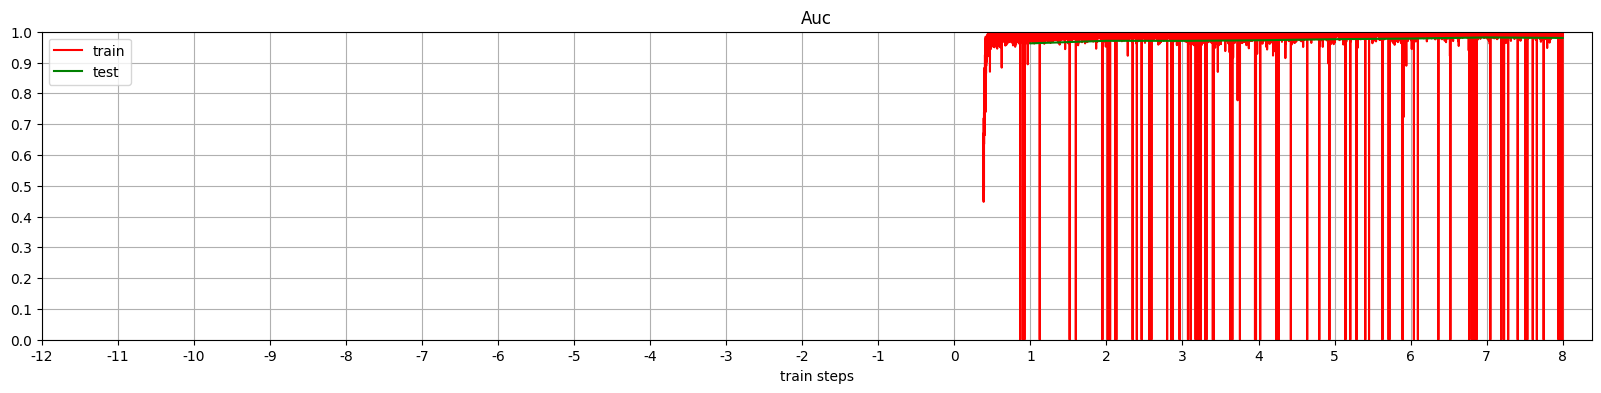

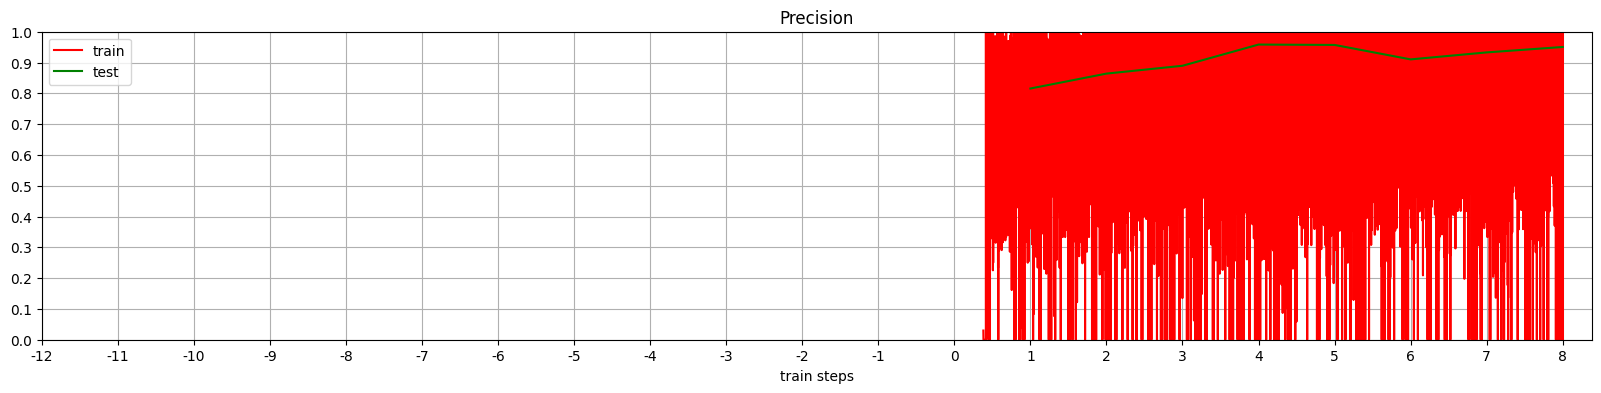

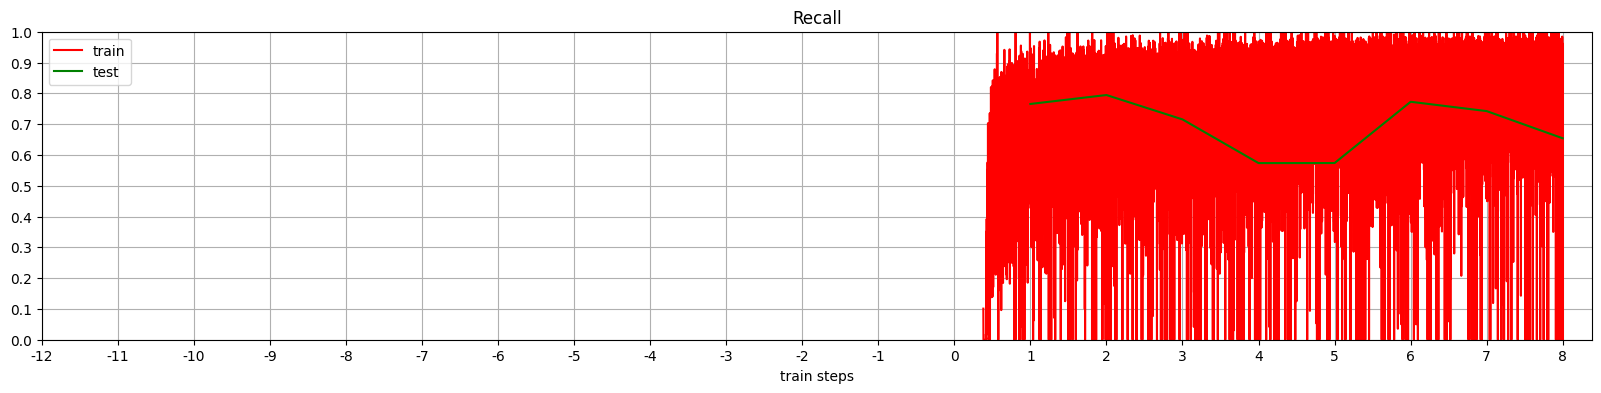

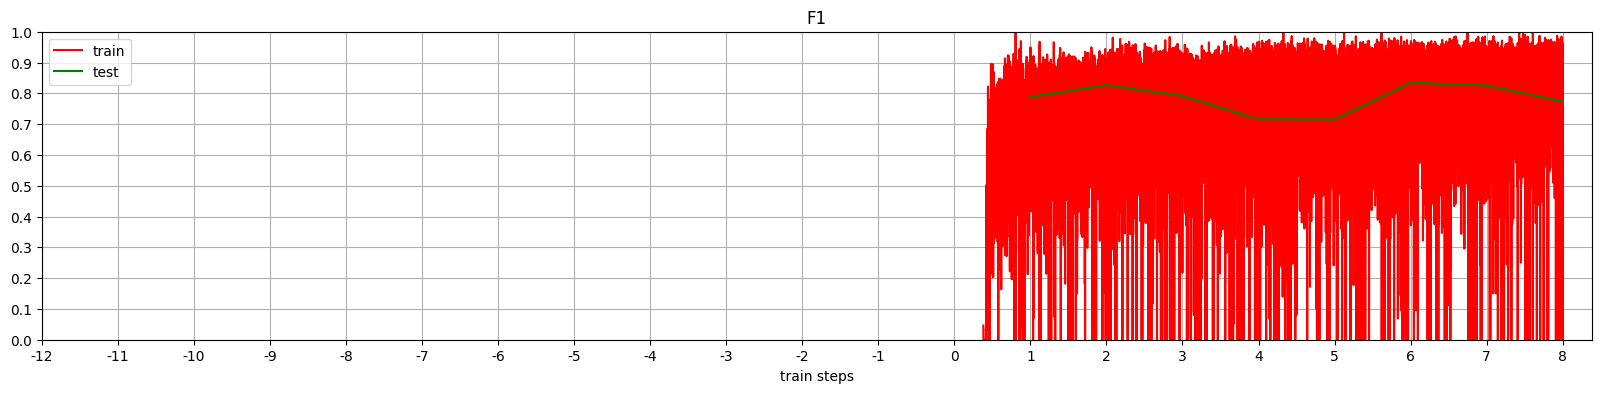

Time:  47.797422309716545
Max 5-mer. Epoch 8: ROC-AUC = 0.98
Max 5-mer. Epoch 8:  Precision = 0.95
Max 5-mer. Epoch 8: Recall = 0.654
Max 5-mer. Epoch 8: F1-score = 0.773
Max 5-mer. Epoch 9 of 10


In [ ]:
metrics = {}

for max_length in range(4, 6):
    groups = generate_subgroups(max_length)
    features_count = len(groups)
    
    np.random.seed(42)
    
    train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_length, groups, lrp_feat = [])

    test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_length, groups, lrp_feat = [])


    params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

    loader_train = DataLoader(train_dataset, **params)
    loader_test = DataLoader(test_dataset, **params)
    
    torch.cuda.empty_cache()
    set_random_seed(42)

    model = DeepCNNLayerNorm_v3(features_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test, max_length)
    
        
    worksheet.append_row(["DeepCNNLayerNorm_v3",
                          f'{features_count}',
                          f'{max_length}',
                          'Kouzine-Wu',
                          '100',
                          f'{val_f1_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.argmax(val_f1_log)}',
                          f'{val_auc_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.mean(times) / 60:.3}'
                         ]
                        )
        
    model_metric = {'Epoch':np.argmax(val_f1_log),
                    'Max F1-score':val_f1_log[np.argmax(val_f1_log)],
                    'ROC-AUC':val_auc_log[np.argmax(val_f1_log)],
                    'Precision':val_pr_log[np.argmax(val_f1_log)],
                    'Recall':val_rec_log[np.argmax(val_f1_log)],
                    'Mean time':np.mean(times) / 60
                   }
    metrics[max_length] = model_metric

In [ ]:
torch.save(model, 'model_CNN_1234_85.pt')

In [42]:
def generate_subgroups_just_n(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    subgroups.extend([''.join(p) for p in product(nucleotides, repeat=n)])
    return subgroups

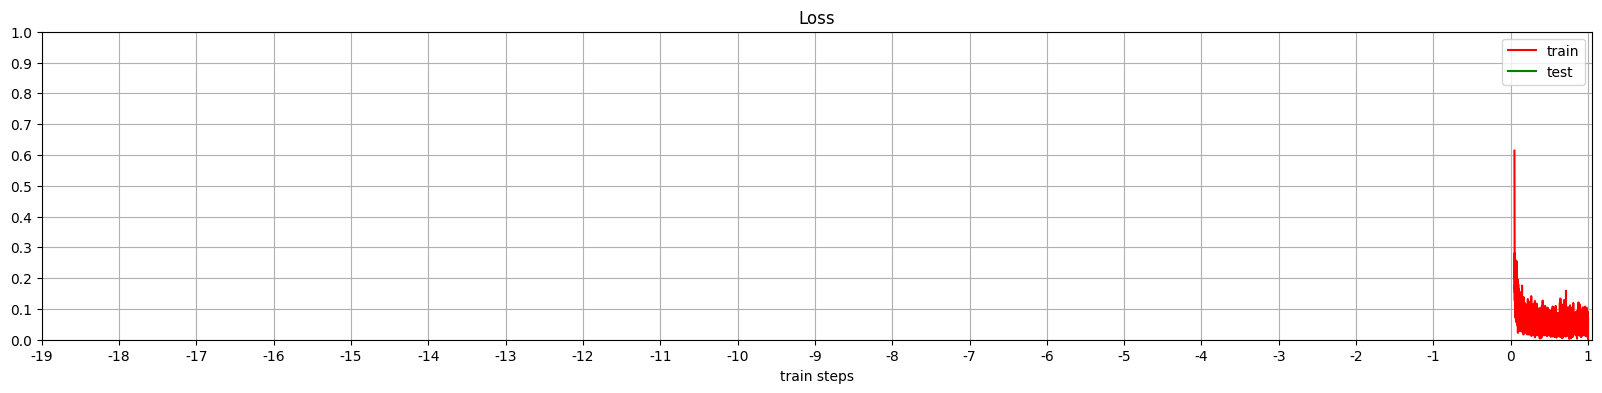

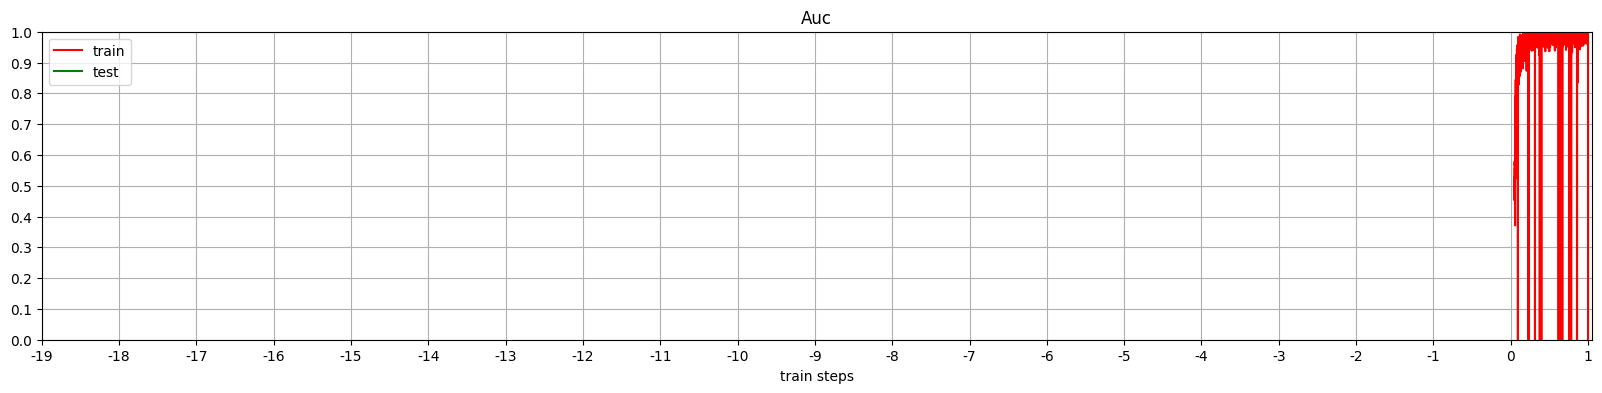

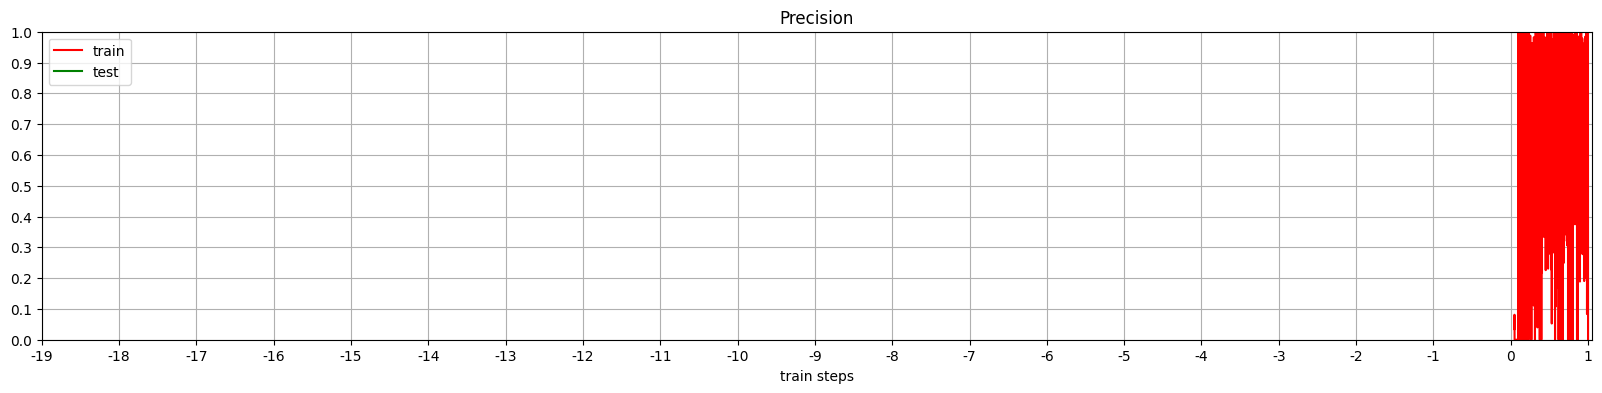

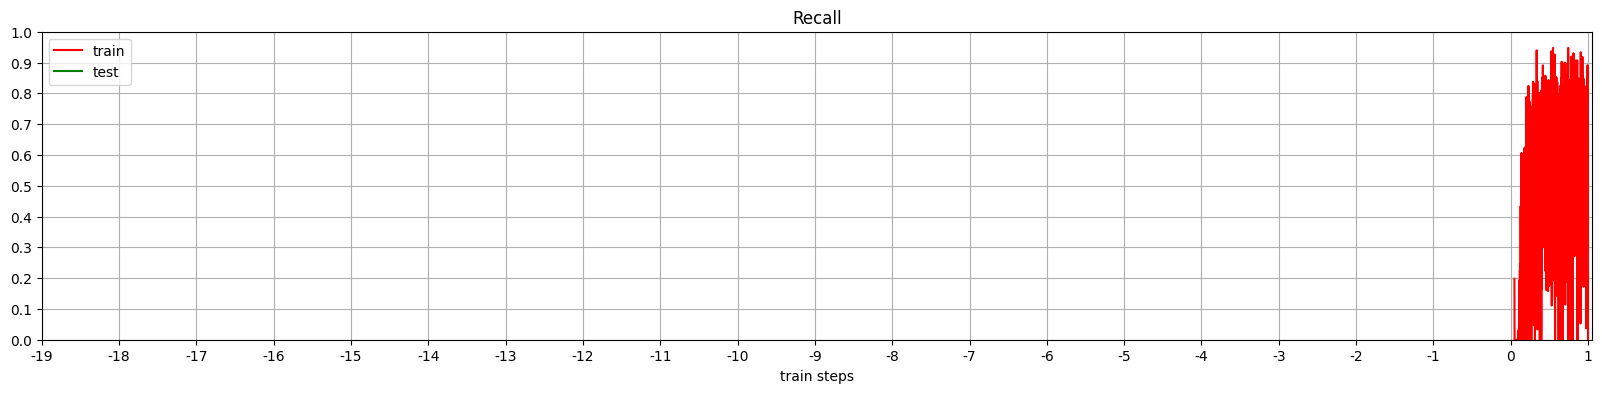

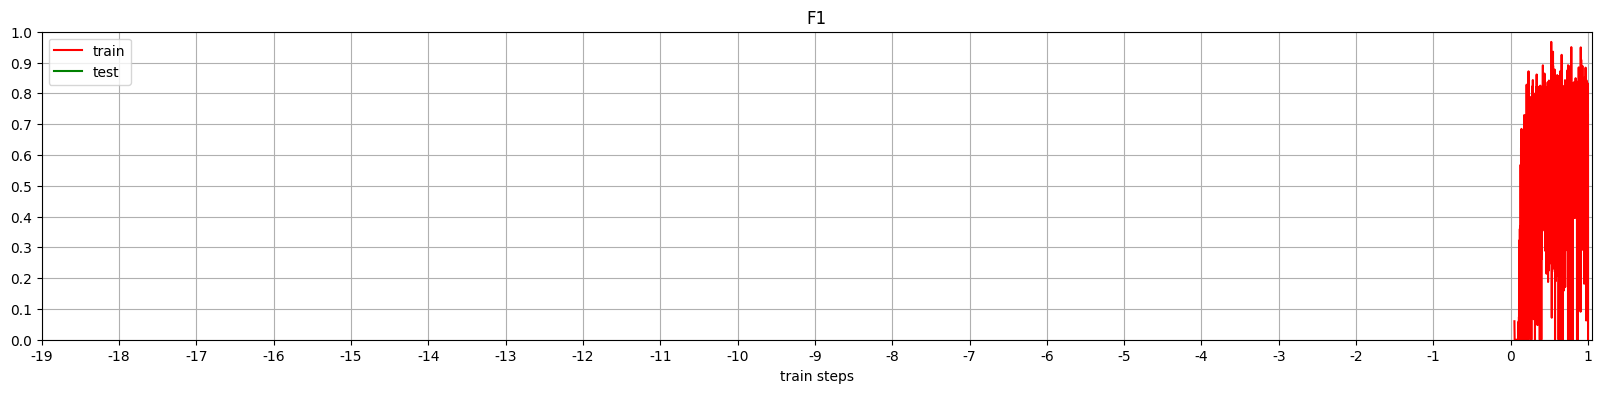

Time:  9.001017340024312
Max 4-mer. Epoch 1: ROC-AUC = 0.95
Max 4-mer. Epoch 1:  Precision = 0.825
Max 4-mer. Epoch 1: Recall = 0.666
Max 4-mer. Epoch 1: F1-score = 0.735
Max 4-mer. Epoch 2 of 10


/home/alapteva/local/python3.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alapteva/local/python3.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alapteva/local/python3.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/ho

In [ ]:
for max_length in range(4, 6):
    groups = generate_subgroups_just_n(max_length)
    features_count = len(groups)
    
    np.random.seed(42)
    train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_length, groups, lrp_feat = [])

    test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_length, groups, lrp_feat = [])


    params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

    loader_train = DataLoader(train_dataset, **params)
    loader_test = DataLoader(test_dataset, **params)
    
    torch.cuda.empty_cache()
    set_random_seed(42)

    model = DeepCNNLayerNorm_v3(features_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test, max_length)
        
    worksheet.append_row(["DeepCNNLayerNorm_v3",
                          f'{features_count}',
                          f'{max_length}',
                          'Kouzine-Wu',
                          '100',
                          f'{val_f1_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.argmax(val_f1_log)}',
                          f'{val_auc_log[np.argmax(val_f1_log)]:.3}',
                          f'{np.mean(times) / 60:.3}'
                         ]
                        )
        
    model_metric = {'Epoch':np.argmax(val_f1_log),
                    'Max F1-score':val_f1_log[np.argmax(val_f1_log)],
                    'ROC-AUC':val_auc_log[np.argmax(val_f1_log)],
                    'Precision':val_pr_log[np.argmax(val_f1_log)],
                    'Recall':val_rec_log[np.argmax(val_f1_log)],
                    'Mean time':np.mean(times) / 60
                   }
    metrics[max_length] = model_metric

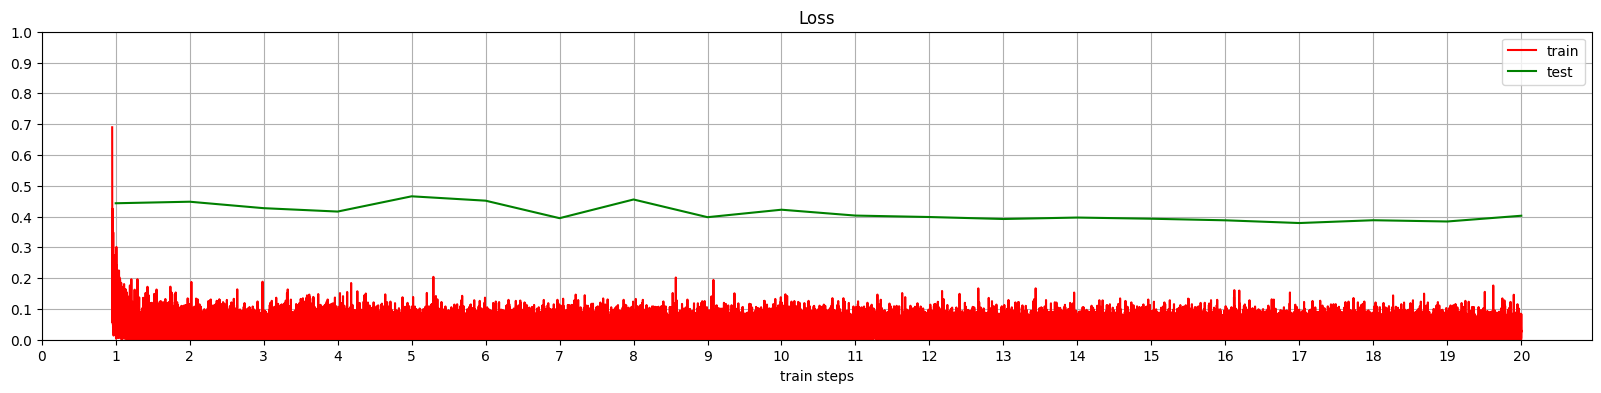

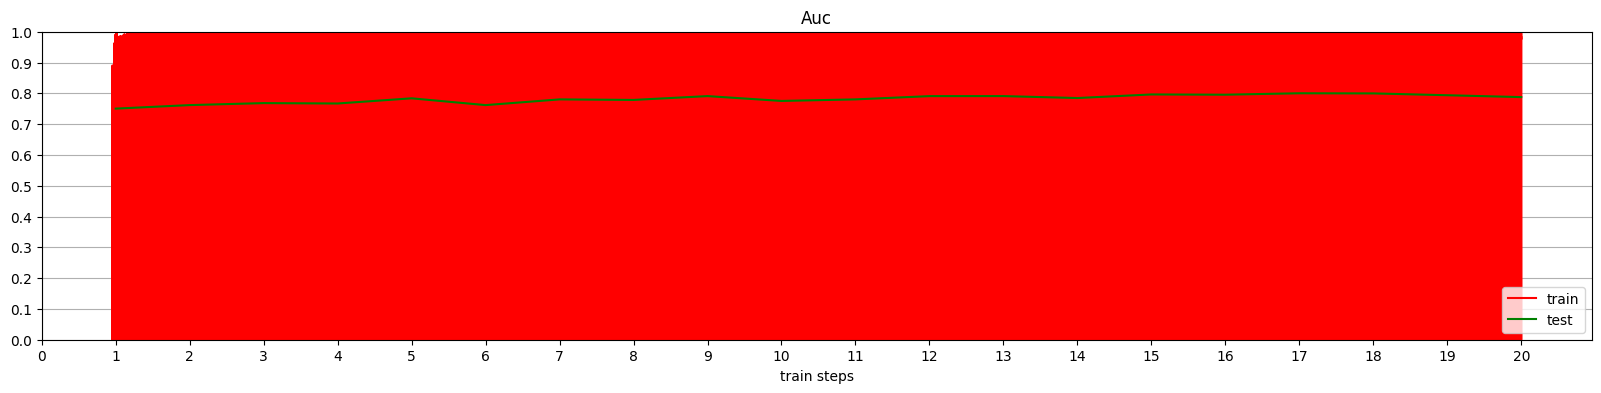

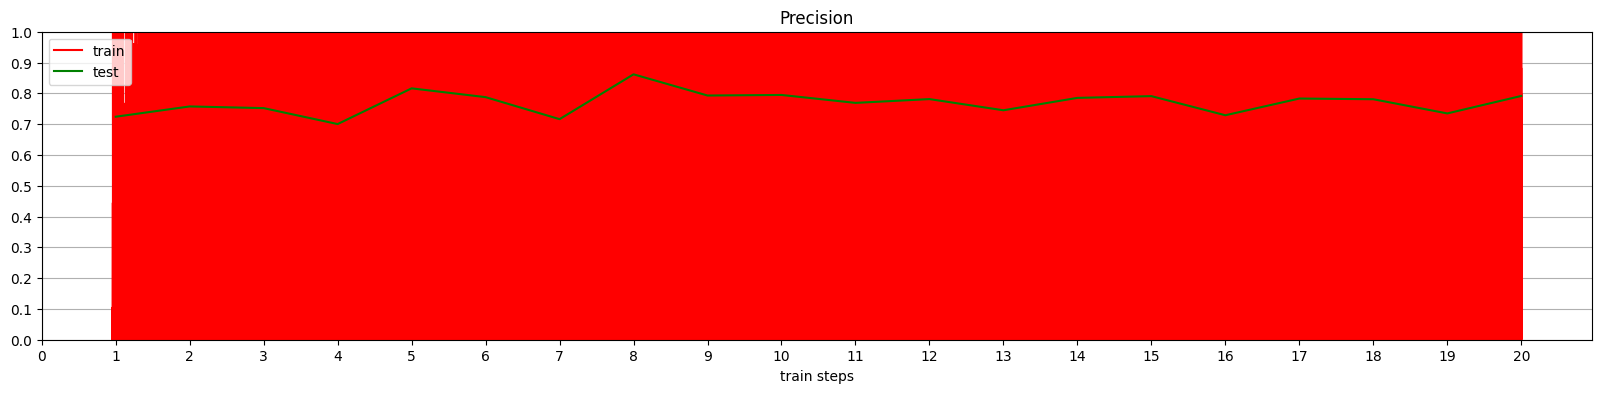

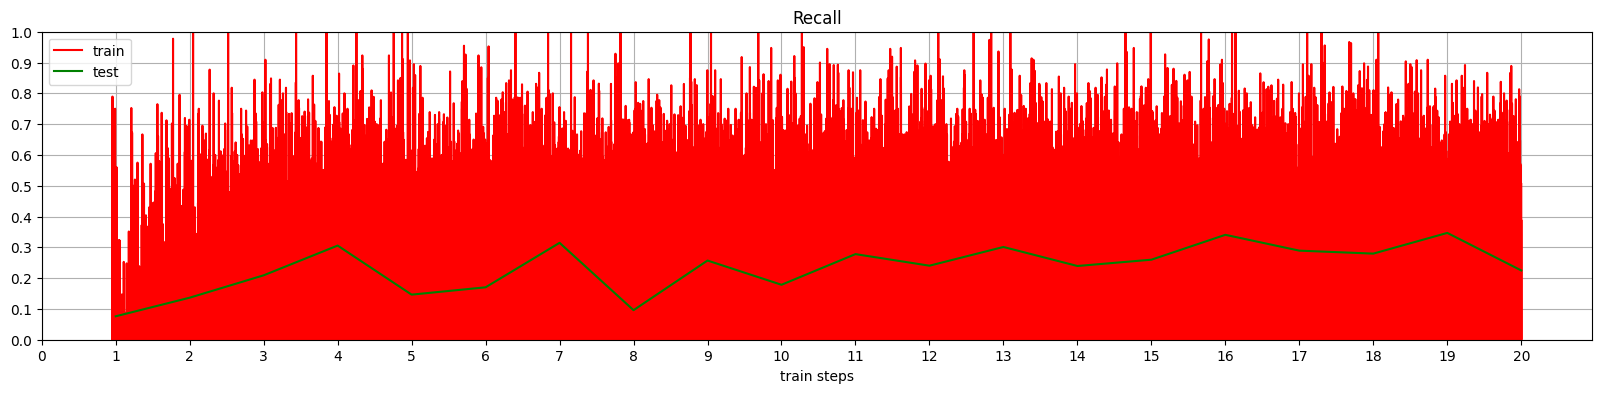

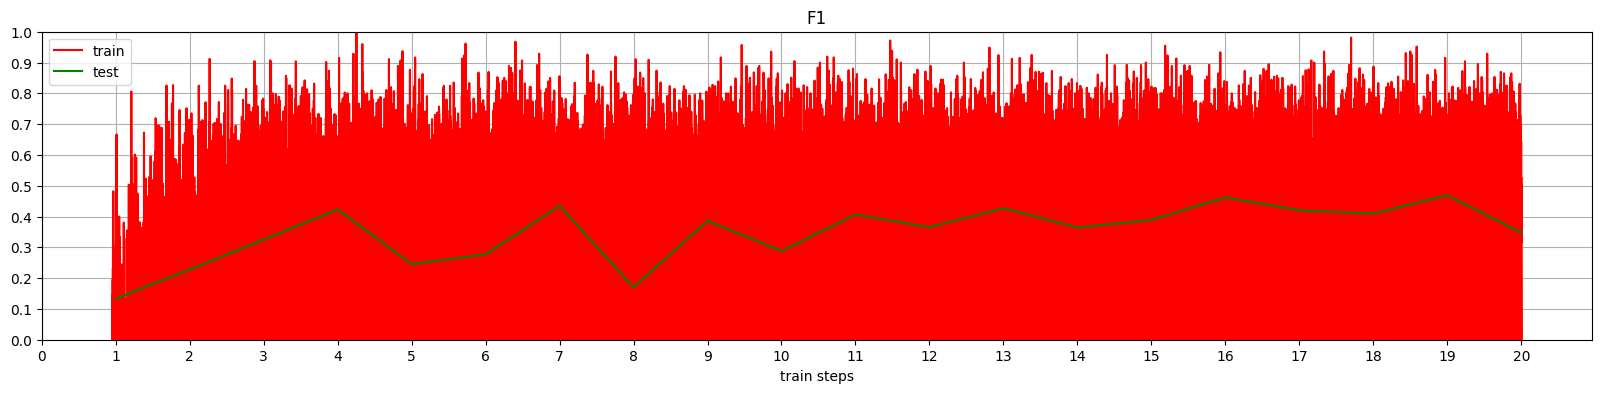

Time:  23.123508846759798
Epoch 20: ROC-AUC = 78.77%
Epoch 20: Precision = 0.791
Epoch 20: Recall = 0.225
Epoch 20: F1-score = 0.348
Final ROC-AUC = 78.77%
Final Precision = 0.791
Final Recall = 0.225
Final F1-score = 0.348


In [13]:
set_random_seed(42)
torch.cuda.empty_cache()

model = DeepCNNBatchNorm()
model = model.cuda()

opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 20)

In [14]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))


Epoch 18
Max F1-score: 46.9345%
ROC-AUC: 79.3803%
Precision: 0.7348
Recall: 0.3468
Mean time for 1 epoch 48.54 minutes
